In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Load the pre-processed mutual fund data
# This CSV contains daily NAV (Net Asset Value) data for all schemes
# with columns: schemeCode, schemeName, date, nav
maindf = pandas.read_csv("final_data.csv")

In [ ]:


# =========================================================
# STAGE 1: BASIC RISK METRICS (Memory-Efficient NumPy Implementation)
# =========================================================
# This section computes fundamental financial metrics using NumPy arrays
# instead of pandas operations to minimize memory footprint on large datasets
# containing thousands of funds with years of daily data.

def _max_drawdown_np(nav: np.ndarray) -> float:
    """
    Calculate Maximum Drawdown - the largest peak-to-trough decline in NAV.
    
    Theory: Max Drawdown measures downside risk by showing the worst loss an investor
    would have experienced if they bought at any point and sold at the worst point after.
    Formula: DD = (Trough NAV - Peak NAV) / Peak NAV
    
    Args:
        nav: Array of NAV values (sorted chronologically)
    Returns:
        Maximum drawdown as a decimal (e.g., -0.25 for -25%)
    """
    nav = nav[np.isfinite(nav)]  # Remove NaN/Inf values
    if nav.size < 2:
        return np.nan
    
    # Compute running maximum (cumulative peak)
    running_max = np.maximum.accumulate(nav)
    
    # Calculate drawdown at each point: (current_nav - peak) / peak
    dd = nav / running_max - 1.0
    
    # Return the minimum (worst) drawdown
    return float(np.min(dd))


def _ulcer_index_np(nav: np.ndarray) -> float:
    """
    Calculate Ulcer Index - a risk measure that emphasizes prolonged downturns.
    
    Theory: Unlike simple volatility, Ulcer Index penalizes sustained losses more heavily.
    It measures the depth and duration of drawdowns. Better for assessing investor pain.
    Formula: UI = sqrt(mean((dd_pct)^2)) where dd_pct are percentage drawdowns
    
    Args:
        nav: Array of NAV values
    Returns:
        Ulcer Index as a percentage value
    """
    nav = nav[np.isfinite(nav)]
    if nav.size < 2:
        return np.nan
    
    # Track running maximum (peak at each point)
    running_max = np.maximum.accumulate(nav)
    
    # Convert drawdowns to percentages
    dd_pct = (nav / running_max - 1.0) * 100.0
    
    # RMS of all drawdown percentages
    return float(np.sqrt(np.mean(dd_pct * dd_pct)))


def _var_cvar_np(ret: np.ndarray, alpha=0.05):
    """
    Calculate Value at Risk (VaR) and Conditional VaR (CVaR/Expected Shortfall).
    
    Theory: 
    - VaR(α): The loss threshold that won't be exceeded with (1-α)% probability
      (e.g., VaR(0.05) = 5th percentile of returns = worst 5% of days)
    - CVaR(α): Average loss in the worst α% of scenarios (tail risk measure)
    
    Args:
        ret: Array of daily returns
        alpha: Tail probability (default 0.05 = 5% tail)
    Returns:
        Tuple of (VaR, CVaR) as decimals
    """
    ret = ret[np.isfinite(ret)]
    if ret.size < 50:  # Need sufficient sample for tail estimation
        return (np.nan, np.nan)
    
    # VaR: percentile at alpha
    q = np.quantile(ret, alpha)
    
    # CVaR: mean of returns worse than VaR
    tail = ret[ret <= q]
    cvar = np.mean(tail) if tail.size else np.nan
    
    return (float(q), float(cvar))


def _trend_slope_log_nav(dates: np.ndarray, nav: np.ndarray) -> float:
    """
    Calculate long-term trend by fitting a log-linear regression on NAV.
    
    Theory: Instead of looking at raw NAV growth (biased by starting value),
    we fit log(NAV) ~ time to extract annualized growth rate independent of scale.
    A positive slope indicates persistent uptrend; negative indicates downtrend.
    
    Args:
        dates: Array of datetime64 values
        nav: Array of NAV values
    Returns:
        Annualized slope of log(NAV) regression
    """
    nav = nav.astype(np.float64)
    if nav.size < 60:  # Need at least 60 days (~3 months) for trend
        return np.nan
    
    # Convert dates to days since start (numeric X axis)
    x = (dates - dates[0]).astype("timedelta64[D]").astype(np.float64)
    y = np.log(nav)
    
    # Filter for finite values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 60:
        return np.nan
    
    # Polyfit: fit y = mx + b, extract slope m
    slope = np.polyfit(x[mask], y[mask], 1)[0] * 365.25  # Convert to annualized
    return float(slope)


def _sortino_np(ret: np.ndarray, periods_per_year=252, rf=0.0) -> float:
    """
    Calculate Sortino Ratio - return per unit of downside risk only.
    
    Theory: Sharpe Ratio treats all volatility equally, but investors care more about
    downside losses. Sortino uses only downside deviation (returns below risk-free rate)
    in the denominator, making it fairer for comparing skewed return distributions.
    Formula: Sortino = (Mean_excess_return / Downside_StdDev) * sqrt(periods_per_year)
    
    Args:
        ret: Array of daily returns
        periods_per_year: Trading days/period (252 for daily, 52 for weekly, etc.)
        rf: Risk-free rate (annualized, e.g., 0.02 for 2%)
    Returns:
        Sortino ratio (higher is better)
    """
    ret = ret[np.isfinite(ret)]
    if ret.size < 2:
        return np.nan
    
    # Convert excess return (return above risk-free rate)
    excess = ret.astype(np.float64) - (rf / periods_per_year)
    
    # Extract only negative excess returns (downside)
    downside = excess[excess < 0]
    if downside.size < 2:
        return np.nan
    
    # Downside standard deviation
    dd = np.std(downside, ddof=1)
    if not np.isfinite(dd) or dd == 0:
        return np.nan
    
    # Sortino: excess return per unit downside risk, annualized
    return float((np.mean(excess) / dd) * np.sqrt(periods_per_year))


# =========================================================
# STAGE 2: DATA PREPARATION (Cleaning + Memory Optimization)
# =========================================================

def prepare_nav_df_lowmem(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and standardize NAV data while minimizing memory footprint.
    
    Process:
    1. Keep only essential columns (schemeCode, schemeName, date, nav)
    2. Type conversion: dates to datetime, codes/navs to numeric
    3. Remove invalid records (missing values, nav <= 0)
    4. Downcast numeric types to smaller dtypes (int32, float32)
    5. Sort globally once for efficient per-fund operations later
    
    Args:
        df: Raw DataFrame with NAV data
    Returns:
        Cleaned, sorted, and downcast DataFrame
    """
    df = df[["schemeCode", "schemeName", "date", "nav"]].copy()

    # Convert to proper types
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["schemeCode"] = pd.to_numeric(df["schemeCode"], errors="coerce")
    df["nav"] = pd.to_numeric(df["nav"], errors="coerce")

    # Remove records with missing values
    df = df.dropna(subset=["schemeCode", "date", "nav"])
    df = df[df["nav"] > 0]  # NAV must be positive

    # Downcast to save memory (important for thousands of funds)
    df["schemeCode"] = df["schemeCode"].astype("int32")
    df["nav"] = df["nav"].astype("float32")
    df["schemeName"] = df["schemeName"].astype("category")

    # CRITICAL: Sort once globally by scheme and date
    # This enables fast numpy slicing by scheme later (no per-fund copies)
    df = df.sort_values(["schemeCode", "date"], kind="mergesort").reset_index(drop=True)
    return df


def add_returns_lowmem(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate daily returns and log-returns for each fund.
    
    Theory:
    - Simple Return: ret_t = (NAV_t - NAV_{t-1}) / NAV_{t-1}
      Used for reporting/aggregation
    - Log Return: logret_t = log(NAV_t / NAV_{t-1})
      Mathematically cleaner for statistical analysis, additive over time
    
    Args:
        df: Cleaned NAV DataFrame (must be sorted by schemeCode, date)
    Returns:
        DataFrame with added ret_1d and logret_1d columns
    """
    df = df.copy()
    g = df.groupby("schemeCode", sort=False, observed=True)

    # Daily returns: percentage change in NAV within each scheme
    df["ret_1d"] = g["nav"].pct_change().astype("float32")
    
    # Log-returns: log-difference (more stable statistically)
    df["logret_1d"] = g["nav"].transform(lambda s: np.log(s).diff()).astype("float32")

    return df


# =========================================================
# STAGE 3: COMPREHENSIVE FEATURE ENGINEERING
# =========================================================

def compute_fund_features_lowmem(
    df: pd.DataFrame,
    periods_per_year=252,
    rf=0.0,
    min_obs=100
) -> pd.DataFrame:
    """
    Compute comprehensive risk-return features for each fund efficiently.
    
    Design Philosophy:
    - Avoids pandas groupby iteration that can allocate multi-GB copies on huge data
    - Uses fast groupby aggregations for simple statistics
    - Computes complex metrics (MDD, Ulcer, VaR/CVaR, Sortino, Trend) via numpy slices
    - Filters funds with insufficient observations early to save computation
    
    Features computed:
    - Basic stats: count, date range, start/end NAV
    - Return moments: mean, std, skewness, kurtosis
    - Performance: CAGR, annualized return/volatility
    - Risk-adjusted: Sharpe ratio, Sortino ratio
    - Drawdown metrics: Maximum Drawdown, Ulcer Index
    - Tail risk: VaR(5%), CVaR(5%)
    - Trend: Log-linear regression slope of NAV
    
    Args:
        df: Cleaned NAV DataFrame with ret_1d, sorted by schemeCode, date
        periods_per_year: Trading periods per year (252 for daily)
        rf: Risk-free rate (annualized)
        min_obs: Minimum observations required (filters small/new funds)
    Returns:
        DataFrame with one row per fund, many feature columns
    """

    # ---- Step 1: Fast group aggregations for basic statistics
    g = df.groupby("schemeCode", sort=False, observed=True)

    base = g.agg(
        schemeName=("schemeName", "first"),
        n_obs=("nav", "size"),                    # Number of observations
        start_date=("date", "first"),             # First date in history
        end_date=("date", "last"),                # Last date in history
        nav_start=("nav", "first"),               # Starting NAV
        nav_end=("nav", "last"),                  # Ending NAV
        ret_mean=("ret_1d", "mean"),              # Mean daily return
        ret_std=("ret_1d", "std"),                # Daily return volatility
        ret_skew=("ret_1d", "skew"),              # Skewness (tail shape)
    ).reset_index()

    # ---- Step 2: Kurtosis computed robustly (handles edge cases)
    kurt = (
        df.groupby("schemeCode", sort=False, observed=True)["ret_1d"]
          .apply(lambda s: s.kurt())               # Excess kurtosis (fat tails)
          .rename("kurtosis")
          .reset_index()
    )

    base = base.merge(kurt, on="schemeCode", how="left")

    # ---- Step 3: Filter funds with insufficient data early
    base = base[base["n_obs"] >= min_obs].reset_index(drop=True)

    # ---- Step 4: Calculate Compound Annual Growth Rate (CAGR)
    # CAGR = (Ending_Value / Starting_Value) ^ (1 / Years) - 1
    # Shows annualized growth rate accounting for compounding
    years = (base["end_date"] - base["start_date"]).dt.days.astype("float64") / 365.25
    base["cagr"] = (base["nav_end"].astype("float64") / base["nav_start"].astype("float64")) ** (1 / years) - 1
    base.loc[~np.isfinite(base["cagr"]), "cagr"] = np.nan

    # ---- Step 5: Annualize return and volatility
    base["ann_return_mean"] = base["ret_mean"].astype("float64") * periods_per_year
    base["ann_vol"] = base["ret_std"].astype("float64") * np.sqrt(periods_per_year)

    # ---- Step 6: Calculate Sharpe Ratio
    # Sharpe = (Expected Return - Risk-Free Rate) / Volatility
    # Measures excess return per unit of total risk
    excess_mean = base["ret_mean"].astype("float64") - (rf / periods_per_year)
    base["sharpe"] = (excess_mean / base["ret_std"].astype("float64")) * np.sqrt(periods_per_year)
    base.loc[~np.isfinite(base["sharpe"]), "sharpe"] = np.nan

    # ---- Step 7: Rename and prepare for complex metric computation
    base = base.rename(columns={"ret_skew": "skew"})

    # ---- Step 8: Build slice map for fast numpy-based metric computation
    # Instead of iterating through groups (which creates copies),
    # we index directly into the globally sorted array using boundaries
    codes_all = df["schemeCode"].to_numpy()
    # Find indices where scheme code changes
    boundaries = np.flatnonzero(np.r_[True, codes_all[1:] != codes_all[:-1], True])

    slice_info = {}
    for i in range(len(boundaries) - 1):
        s = boundaries[i]
        e = boundaries[i + 1]
        code = int(codes_all[s])
        slice_info[code] = (s, e)  # Store start and end index for each scheme

    # ---- Step 9: Pre-pull arrays once from DataFrame (expensive operation)
    # Convert to numpy for fast access in loops
    nav_all = df["nav"].to_numpy(dtype=np.float32)
    ret_all = df["ret_1d"].to_numpy(dtype=np.float32)
    date_all = df["date"].to_numpy()

    # ---- Step 10: Compute complex per-fund metrics using numpy slices
    # This avoids pandas groupby iteration which allocates copies
    mdd_list = []
    ulcer_list = []
    var5_list = []
    cvar5_list = []
    sortino_list = []
    trend_list = []

    for code in base["schemeCode"].astype(int).tolist():
        s, e = slice_info[code]  # Get slice boundaries for this scheme
        nav = nav_all[s:e].astype(np.float64)
        ret = ret_all[s:e].astype(np.float64)
        dates = date_all[s:e]

        # Append computed metrics
        mdd_list.append(_max_drawdown_np(nav))
        ulcer_list.append(_ulcer_index_np(nav))
        v, cv = _var_cvar_np(ret, alpha=0.05)
        var5_list.append(v)
        cvar5_list.append(cv)
        sortino_list.append(_sortino_np(ret, periods_per_year=periods_per_year, rf=rf))
        trend_list.append(_trend_slope_log_nav(dates, nav))

    # ---- Step 11: Attach computed metrics to base features
    base["max_drawdown"] = mdd_list
    base["ulcer_index"] = ulcer_list
    base["var_5"] = var5_list
    base["cvar_5"] = cvar5_list
    base["sortino"] = sortino_list
    base["trend_slope_log_nav"] = trend_list

    # ---- Step 12: Select final lean feature set (reduces memory for downstream steps)
    keep = [
        "schemeCode", "schemeName", "n_obs", "start_date", "end_date",
        "cagr", "ann_return_mean", "ann_vol",
        "max_drawdown", "ulcer_index", "var_5", "cvar_5",
        "sharpe", "sortino", "skew", "kurtosis", "trend_slope_log_nav"
    ]

    return base[keep].copy()


# =========================================================
# STAGE 4: RISK CATEGORIZATION + RANKING
# =========================================================

def assign_risk_bucket(features: pd.DataFrame) -> pd.DataFrame:
    """
    Categorize funds into three risk buckets based on volatility and drawdown.
    
    Methodology:
    1. Rank funds by volatility percentile (0-1 scale)
    2. Rank funds by max drawdown (higher=better, i.e., less negative)
    3. Combine: risk_score = 0.6 * vol_rank + 0.4 * (1 - mdd_rank)
    4. Tertile split: Conservative (≤33%), Moderate (33-66%), Aggressive (>66%)
    
    This provides investor-friendly risk segmentation without complex modeling.
    
    Args:
        features: DataFrame with computed fund features
    Returns:
        DataFrame with added risk_bucket and risk_score columns
    """
    f = features.copy()
    
    # Percentile ranks: funds with higher vol get higher rank
    f["vol_rank"] = f["ann_vol"].rank(pct=True)
    
    # For drawdown: more negative = worse, so less negative gets higher rank
    # rank(pct=True) gives higher rank to higher values (closer to 0)
    f["mdd_rank"] = f["max_drawdown"].rank(pct=True)

    # Combined risk score: weight volatility more (60%) than drawdown (40%)
    f["risk_score"] = 0.6 * f["vol_rank"] + 0.4 * (1 - f["mdd_rank"])

    # Split into three equal groups
    q1, q2 = f["risk_score"].quantile([0.33, 0.66]).values
    f["risk_bucket"] = np.where(
        f["risk_score"] <= q1, "Conservative",
        np.where(f["risk_score"] <= q2, "Moderate", "Aggressive")
    )
    return f


def rank_funds(features: pd.DataFrame, w_return=1.0, w_vol=0.7, w_mdd=0.7):
    """
    Rank all funds using a composite score balancing return, risk, and downside.
    
    Methodology:
    1. Standardize key metrics (CAGR, Ann Vol, Max Drawdown, Sharpe) using z-scores
    2. Construct composite score with weighted components:
       - CAGR: positive (higher is better)
       - Sharpe: positive (higher is better)
       - Ann Vol: negative (lower is better)
       - Max Drawdown: positive (less negative is better)
    3. Sort by score (highest first)
    
    This provides a holistic ranking, preferable to single-metric optimization.
    
    Args:
        features: Fund feature DataFrame
        w_return: Weight on CAGR (default 1.0)
        w_vol: Weight on volatility penalty (default 0.7)
        w_mdd: Weight on max drawdown (default 0.7)
    Returns:
        Ranked DataFrame sorted by score descending
    """
    f = features.copy()
    cols = ["cagr", "ann_vol", "max_drawdown", "sharpe"]
    X = f[cols].copy()

    # Impute missing values with median (robust to outliers)
    for c in cols:
        X[c] = X[c].fillna(X[c].median())

    # Standardize to z-scores (mean=0, std=1)
    scaler = StandardScaler()
    Z = pd.DataFrame(scaler.fit_transform(X.values), columns=cols)

    # Composite score: balance multiple objectives
    score = (
        w_return * Z["cagr"]         # Reward returns
        + 0.5 * Z["sharpe"]          # Reward risk-adjusted returns
        - w_vol * Z["ann_vol"]       # Penalize volatility
        + w_mdd * Z["max_drawdown"]  # Reward smaller drawdowns
    )
    f["score"] = score.values
    return f.sort_values("score", ascending=False).reset_index(drop=True)


def recommend_by_risk_profile(risk_profile: str, features_with_bucket: pd.DataFrame, k=10) -> pd.DataFrame:
    """
    Recommend top-k funds matching a specific risk profile.
    
    Args:
        risk_profile: "Conservative", "Moderate", or "Aggressive"
        features_with_bucket: Features DataFrame with risk_bucket column
        k: Number of recommendations
    Returns:
        Top-k funds in that bucket, sorted by Sharpe + CAGR
    """
    prof = risk_profile.strip().lower()
    mapping = {"conservative": "Conservative", "moderate": "Moderate", "aggressive": "Aggressive"}
    if prof not in mapping:
        raise ValueError("risk_profile must be one of: Conservative, Moderate, Aggressive")

    bucket = mapping[prof]
    f = features_with_bucket[features_with_bucket["risk_bucket"] == bucket].copy()
    f = f.sort_values(["sharpe", "cagr"], ascending=False).head(k)

    return f[["schemeCode", "schemeName", "risk_bucket", "cagr", "ann_vol", "max_drawdown", "sharpe"]].reset_index(drop=True)


# =========================================================
# STAGE 5: SIMILARITY-BASED MATCHING (Top-K via Cosine Distance)
# =========================================================
# Design: Avoid computing full NxN similarity matrix (memory/time O(n²))
# Instead: normalize features to unit vectors, compute similarity with target only

def fit_feature_matrix(features: pd.DataFrame, feature_cols: list[str]):
    """
    Prepare feature matrix for similarity computation (cosine distance in feature space).
    
    Process:
    1. Extract feature columns and impute missing values with median
    2. Standardize using z-score normalization (mean=0, std=1)
    3. Normalize to unit vectors in feature space (L2 norm = 1)
       - Unit vectors enable cosine similarity via simple dot product
    4. Return normalized matrix + metadata for fast top-k lookup
    
    Args:
        features: DataFrame with feature columns
        feature_cols: List of columns to use in similarity
    Returns:
        Tuple of (normalized_feature_matrix, scheme_codes, scaler)
    """
    X = features[feature_cols].copy()
    
    # Impute missing values with column median (robust to outliers)
    X = X.apply(lambda c: c.fillna(c.median()), axis=0)

    # Standardize: X = (X - mean) / std
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values).astype(np.float32)

    # Normalize to unit vectors: for cosine similarity, ||X|| = 1
    # cosine_sim(a, b) = (a · b) / (||a|| ||b||) = a · b (when both unit vectors)
    norms = np.linalg.norm(Xs, axis=1, keepdims=True)
    Xn = Xs / np.clip(norms, 1e-12, None)

    codes = features["schemeCode"].to_numpy(dtype=np.int32)
    return Xn, codes, scaler


def recommend_similar_topk(target_code: int, features: pd.DataFrame, Xn: np.ndarray, codes: np.ndarray, k=10) -> pd.DataFrame:
    """
    Find and rank the k most similar funds to a target fund.
    
    Method:
    1. Locate target in normalized feature space
    2. Compute cosine similarity: sim = normalized_features @ target_vector
    3. Use efficient partial sort (argpartition) to find top-k without full sort
    4. Return top-k with similarity scores
    
    Time complexity: O(n) for dot product + O(n log k) for partial sort << O(n²)
    
    Args:
        target_code: schemeCode of fund to find similar matches for
        features: Full feature DataFrame
        Xn: Pre-normalized feature matrix (unit vectors)
        codes: Scheme codes corresponding to rows of Xn
        k: Number of similar funds to return
    Returns:
        DataFrame with top-k similar funds and similarity scores
    """
    # Build fast lookup: code -> index in Xn
    idx_map = {int(c): i for i, c in enumerate(codes)}
    if int(target_code) not in idx_map:
        raise ValueError("Target code not found (maybe filtered by min_obs).")

    i = idx_map[int(target_code)]
    
    # Cosine similarity = dot product with unit vectors
    sims = Xn @ Xn[i]

    # Exclude self-similarity
    sims[i] = -np.inf
    k = min(k, len(sims) - 1)

    # Efficient top-k: argpartition finds k largest without full sort
    top_idx = np.argpartition(-sims, kth=k)[:k]
    
    # Sort the top-k by similarity descending
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    rec_codes = codes[top_idx]
    rec = features.set_index("schemeCode").loc[rec_codes, ["schemeName", "cagr", "ann_vol", "max_drawdown", "sharpe"]].copy()
    rec["similarity"] = sims[top_idx]
    return rec.reset_index().sort_values("similarity", ascending=False)


# =========================================================
# STAGE 6: DIVERSIFICATION ANALYSIS (Low-Correlation Discovery)
# =========================================================

def build_wide_returns_lowmem(df_clean: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot cleaned returns to wide format: rows=dates, columns=schemeCodes, values=daily returns.
    
    WARNING: This pivot can be large if you have thousands of funds with years of daily data.
    Consider sampling dates or using sparse matrices for very large universes.
    
    Returns stored as float32 to minimize memory.
    
    Args:
        df_clean: Clean DataFrame with date, schemeCode, ret_1d
    Returns:
        Wide DataFrame (date x schemeCode)
    """
    wide = df_clean.pivot(index="date", columns="schemeCode", values="ret_1d")
    return wide.astype("float32")


def recommend_diversifiers_proxy(
    wide_returns: pd.DataFrame,
    portfolio_codes: list[int],
    features: pd.DataFrame,
    k: int = 10
) -> pd.DataFrame:
    """
    Recommend low-correlation funds to diversify an existing portfolio.
    
    Theory: 
    - Diversification reduces risk through uncorrelated assets
    - A proxy portfolio: average returns of existing holdings
    - Best diversifiers: funds with lowest correlation to proxy
    
    Method:
    1. Compute proxy series: average returns of portfolio holdings
    2. Correlate each fund with proxy (including zeros and NaNs handling)
    3. Select k funds with lowest correlation (best diversifiers)
    4. Filter: ensure candidates exist in feature table (post-filtering)
    
    Args:
        wide_returns: Wide return DataFrame (date x schemeCode)
        portfolio_codes: List of scheme codes in current portfolio
        features: Feature DataFrame (used for filtering/enrichment)
        k: Number of diversifiers to recommend
    Returns:
        Top-k diversifiers with correlation scores
    """

    # Step 1: Verify portfolio codes exist in return matrix
    present = [int(c) for c in portfolio_codes if int(c) in wide_returns.columns]
    if len(present) == 0:
        raise ValueError("None of the portfolio codes exist in the return matrix (wide_returns).")

    # Step 2: Create proxy (portfolio average daily return)
    port_series = wide_returns[present].mean(axis=1)

    # Step 3: Correlation of each fund with portfolio proxy
    corr_with_port = wide_returns.corrwith(port_series, axis=0)
    
    # Remove portfolio holdings from candidate pool (only suggest new additions)
    corr_with_port = corr_with_port.drop(labels=present, errors="ignore").sort_values()

    # Get extra candidates to account for filtering losses
    picks = corr_with_port.head(max(k * 5, k))

    # Step 4: Intersect with features table (respect min_obs filter)
    # Avoids KeyError when features filtered but wide_returns includes those codes
    feat_idx = features["schemeCode"].astype(int)
    feat_set = set(feat_idx.tolist())

    available_codes = [int(c) for c in picks.index.tolist() if int(c) in feat_set]

    if len(available_codes) == 0:
        raise ValueError(
            "No diversification candidates are available in features table after filtering. "
            "Try lowering min_obs or rebuild features."
        )

    # Keep top-k available
    available_codes = available_codes[:k]
    picks = corr_with_port.loc[available_codes]

    # Step 5: Enrich with fund features
    out = (
        features.set_index(features["schemeCode"].astype(int))
        .loc[available_codes, ["schemeName", "cagr", "ann_vol", "max_drawdown", "sharpe"]]
        .copy()
    )
    out["corr_with_portfolio_proxy"] = picks.values

    return out.reset_index(names="schemeCode").sort_values("corr_with_portfolio_proxy", ascending=True)


# =========================================================
# STAGE 7: END-TO-END PIPELINE ORCHESTRATOR
# =========================================================

def build_recommenders_lowmem(
    df: pd.DataFrame,
    periods_per_year=252,
    rf=0.0,
    min_obs=100,
    build_wide_returns=False
):
    """
    End-to-end low-memory pipeline: clean → compute features → fit recommenders.
    
    Workflow:
    1. Clean NAV data and add returns
    2. Engineer comprehensive features (15+ metrics per fund)
    3. Normalize and fit similarity feature matrix
    4. Assign risk buckets and rank funds
    5. Optionally build wide return matrix for diversification (memory-intensive)
    
    Args:
        df: Raw NAV DataFrame
        periods_per_year: Trading periods/year (252 for daily)
        rf: Risk-free rate (annualized)
        min_obs: Minimum observations per fund
        build_wide_returns: Whether to create wide return matrix (set False to save RAM)
    Returns:
        Dictionary with all computed data and models:
          - df_clean: Cleaned data
          - features: Fund features
          - Xn, codes, scaler: Similarity model
          - features_bucketed: With risk buckets
          - ranked: Ranked funds
          - wide_returns: Return matrix (if requested)
    """
    df0 = prepare_nav_df_lowmem(df)
    df1 = add_returns_lowmem(df0)

    features = compute_fund_features_lowmem(df1, periods_per_year=periods_per_year, rf=rf, min_obs=min_obs)

    feature_cols = [
        "cagr", "ann_vol", "max_drawdown", "sharpe", "sortino",
        "ulcer_index", "var_5", "cvar_5",
        "skew", "kurtosis", "trend_slope_log_nav"
    ]
    feature_cols = [c for c in feature_cols if c in features.columns]

    Xn, codes, scaler = fit_feature_matrix(features, feature_cols)

    features_bucketed = assign_risk_bucket(features)
    ranked = rank_funds(features)

    wide_returns = None
    if build_wide_returns:
        wide_returns = build_wide_returns_lowmem(df1)

    return {
        "df_clean": df1,
        "features": features,
        "feature_cols": feature_cols,
        "Xn": Xn,
        "codes": codes,
        "scaler": scaler,
        "features_bucketed": features_bucketed,
        "ranked": ranked,
        "wide_returns": wide_returns
    }


# =========================================================
# STAGE 8: VISUALIZATION & ANALYSIS UTILITIES
# =========================================================

def get_nav_series(df_clean: pd.DataFrame, scheme_code: int):
    """
    Extract NAV time-series for a specific fund.
    
    Args:
        df_clean: Clean DataFrame
        scheme_code: Fund scheme code
    Returns:
        DataFrame with date and NAV columns
    """
    g = df_clean[df_clean["schemeCode"] == scheme_code].sort_values("date")
    if g.empty:
        raise ValueError(f"schemeCode={scheme_code} not found.")
    return g[["date", "nav"]].dropna()


def plot_nav_case_study(art: dict, target_code: int, k_similar=5, window_years=5):
    """
    Visualize NAV trajectories: target fund vs top-k similar funds.
    
    Useful for:
    - Assessing whether similarity recommendations make intuitive sense
    - Understanding relative performance in recent periods
    - Identifying regime changes
    
    Args:
        art: Dict returned from build_recommenders_lowmem
        target_code: Target scheme code
        k_similar: Number of similar funds to plot
        window_years: Time window to display (recent)
    """
    df_clean = art["df_clean"]
    features = art["features"]

    sim = recommend_similar_topk(target_code, features, art["Xn"], art["codes"], k=k_similar)

    last_date = df_clean["date"].max()
    from_date = last_date - pd.Timedelta(days=int(365 * window_years))

    plt.figure()
    t = get_nav_series(df_clean, target_code)
    t = t[t["date"] >= from_date]
    plt.plot(t["date"], t["nav"], label=f"Target {target_code}", linewidth=2)

    for sc in sim["schemeCode"].astype(int).tolist():
        s = get_nav_series(df_clean, sc)
        s = s[s["date"] >= from_date]
        plt.plot(s["date"], s["nav"], label=f"Similar {sc}")

    plt.title(f"NAV Case Study (last {window_years}Y) Target={target_code}")
    plt.xlabel("Date")
    plt.ylabel("NAV")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return sim


def paper_tables(art: dict, top_n=20):
    """
    Generate publication-ready summary tables:
    1. Top-ranked funds and their metrics
    2. Risk bucket statistics (medians by bucket)
    
    Args:
        art: Dict from build_recommenders_lowmem
        top_n: Number of top funds to display
    """
    top_ranked = art["ranked"][["schemeCode","schemeName","score","cagr","ann_vol","max_drawdown","sharpe"]].head(top_n)
    print(f"\n=== Top {top_n} Ranked Funds ===")
    print(top_ranked.to_string(index=False))

    bucketed = art["features_bucketed"]
    summary = bucketed.groupby("risk_bucket").agg(
        n_funds=("schemeCode","count"),
        cagr_median=("cagr","median"),
        ann_vol_median=("ann_vol","median"),
        max_drawdown_median=("max_drawdown","median"),
        sharpe_median=("sharpe","median"),
        cvar_5_median=("cvar_5","median"),
    ).reset_index()

    print("\n=== Risk Bucket Summary (Medians) ===")
    print(summary.to_string(index=False))

    return top_ranked, summary


def ablation_similarity_comparison_lowmem(
    art: dict,
    target_code: int,
    k: int = 10,
    simple_cols: list[str] | None = None
):
    """
    Ablation study: compare full feature model vs simple baseline model.
    
    Purpose: Validate that complex features improve recommendations
    
    Models:
    - Simple: CAGR, Ann Vol, Max Drawdown, Sharpe (4 features)
    - Full: 11 features including tail risk, skew, kurtosis, trend
    
    Metrics:
    - Overlap: How many recommendations agree (0-k)
    - Jaccard: Set overlap / union (0-1 scale)
    
    Args:
        art: Dict from build_recommenders_lowmem
        target_code: Target fund
        k: Top-k to compare
        simple_cols: Features for simple model (default: basic 4)
    Returns:
        Tuple of (simple_recs, full_recs, comparison_table)
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler

    if simple_cols is None:
        simple_cols = ["cagr", "ann_vol", "max_drawdown", "sharpe"]

    if "Xn" not in art or "codes" not in art:
        raise ValueError("Missing art['Xn'] or art['codes']. Rebuild with build_recommenders_lowmem().")

    features = art["features"]

    # ---------- Full model recs ----------
    full = recommend_similar_topk(
        target_code,
        features,
        art["Xn"],
        art["codes"],
        k=k
    ).copy()

    # ---------- Simple model recs ----------
    X = features[simple_cols].copy()
    X = X.apply(lambda c: c.fillna(c.median()), axis=0)

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values).astype(np.float32)
    norms = np.linalg.norm(Xs, axis=1, keepdims=True)
    Xn_simple = Xs / np.clip(norms, 1e-12, None)

    codes = features["schemeCode"].to_numpy(dtype=np.int32)

    simple = recommend_similar_topk(
        target_code,
        features,
        Xn_simple,
        codes,
        k=k
    ).copy()

    # ---------- Overlap metrics ----------
    set_full = set(full["schemeCode"].tolist())
    set_simple = set(simple["schemeCode"].tolist())
    overlap = len(set_full & set_simple)
    jaccard = overlap / len(set_full | set_simple) if (set_full | set_simple) else np.nan

    print("\n=== Ablation Study (LOW-MEM) ===")
    print(f"Target={target_code} | Top-{k} overlap={overlap} | Jaccard={jaccard:.3f}")

    # Side-by-side
    s1 = simple[["schemeCode", "schemeName", "similarity"]].rename(columns={"similarity": "simple_similarity"})
    s2 = full[["schemeCode", "schemeName", "similarity"]].rename(columns={"similarity": "full_similarity"})
    side = pd.concat([s1.reset_index(drop=True), s2.reset_index(drop=True)], axis=1)

    print("\nSide-by-side recommendations:")
    print(side.to_string(index=False))

    # Plot
    plt.figure()
    plt.plot(range(1, len(simple) + 1), simple["similarity"].values, marker="o", label="Simple")
    plt.plot(range(1, len(full) + 1), full["similarity"].values, marker="o", label="Full")
    plt.title("Ablation: Similarity Scores by Rank (LOW-MEM)")
    plt.xlabel("Rank")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return simple, full, side


# =========================================================
# USAGE EXAMPLES (Edit scheme codes and parameters as needed)
# =========================================================
# maindf = ... your full dataframe ...
#
# Build recommenders (set build_wide_returns=True only if you have enough RAM)
# art = build_recommenders_lowmem(maindf, min_obs=100, build_wide_returns=False)
#
# Similar funds
# sim = recommend_similar_topk(100027, art["features"], art["Xn"], art["codes"], k=10)
# print(sim)
#
# Risk profile
# risk = recommend_by_risk_profile("Conservative", art["features_bucketed"], k=10)
# print(risk)
#
# Ranking
# print(art["ranked"].head(20))
#
# Appendix B: Case study plot
# sim5 = plot_nav_case_study(art, target_code=100027, k_similar=5, window_years=5)
#
# Appendix B: Tables
# top_ranked, bucket_summary = paper_tables(art, top_n=20)
#
# Appendix B: Ablation
# simple, full, side = ablation_similarity_comparison_lowmem(art, target_code=100027, k=10)
#
# Diversification (requires wide returns pivot)
# art2 = build_recommenders_lowmem(maindf, min_obs=100, build_wide_returns=True)
# div = recommend_diversifiers_proxy(art2["wide_returns"], [100027, 123456, 777777], art2["features"], k=10)
# print(div)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# =========================================================
# APPENDIX B: ADVANCED VISUALIZATION & ANALYSIS TOOLS
# =========================================================
# These tools support deeper investigation of recommendations and fund landscapes.
# They build on the core pipeline (art dictionary from build_recommenders_lowmem).


# ======================== UTILITY FUNCTIONS ==========================

def build_similarity_from_feature_cols(features: pd.DataFrame, feature_cols: list[str]):
    """
    Construct cosine similarity matrix from a custom feature set.
    
    Useful for:
    - Ablation studies (test different feature combinations)
    - Rebuilding similarity with alternative feature selections
    - Comparing full vs. simple models
    
    Args:
        features: Fund features DataFrame
        feature_cols: Columns to use for similarity
    Returns:
        Tuple: (standardized_feature_matrix, scaler, similarity_dataframe)
    """
    X = features[feature_cols].copy()
    # Impute missing with median
    X = X.apply(lambda c: c.fillna(c.median()), axis=0)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values)
    idx = features["schemeCode"].values
    Xs_df = pd.DataFrame(Xs, columns=feature_cols, index=idx)
    # Compute cosine similarity between all funds
    sim = cosine_similarity(Xs_df.values)
    sim_df = pd.DataFrame(sim, index=idx, columns=idx)
    return Xs_df, scaler, sim_df


def get_nav_series(df_clean: pd.DataFrame, scheme_code: int):
    """
    Extract NAV time series for a fund (used for plotting).
    
    Args:
        df_clean: Cleaned NAV DataFrame
        scheme_code: Scheme code to extract
    Returns:
        DataFrame with date and nav columns
    """
    g = df_clean[df_clean["schemeCode"] == scheme_code].sort_values("date")
    if g.empty:
        raise ValueError(f"schemeCode={scheme_code} not found in df_clean.")
    return g[["date", "nav"]].dropna()


# ======================== CASE STUDY ANALYSIS ==========================

def case_study_report(
    art: dict,
    target_scheme_code: int,
    portfolio_codes: list[int] | None = None,
    top_k_similar: int = 5,
    top_k_div: int = 5,
    nav_window: str | None = "5Y",
):
    """
    Generate comprehensive case study report for a fund:
    1. NAV trajectory plot (target vs. similar funds)
    2. Similar funds recommendation table
    3. Diversification recommendations (if portfolio provided)
    4. Comparison metrics
    
    Args:
        art: Dictionary from build_recommenders_lowmem
        target_scheme_code: Fund to analyze
        portfolio_codes: Optional list of funds in current portfolio
        top_k_similar: Number of similar funds to show
        top_k_div: Number of diversifiers to show
        nav_window: "1Y", "3Y", "5Y", or None for full history
    Returns:
        Dictionary with similar, diversifiers, and compare_table
    """
    df_clean = art["df_clean"]
    features = art["features"]
    wide_returns = art["wide_returns"]

    # ----- Determine time window for NAV plot -----
    from_date = None
    if nav_window is not None:
        last_date = df_clean["date"].max()
        if nav_window.upper() == "1Y":
            from_date = last_date - pd.Timedelta(days=365)
        elif nav_window.upper() == "3Y":
            from_date = last_date - pd.Timedelta(days=int(365 * 3))
        elif nav_window.upper() == "5Y":
            from_date = last_date - pd.Timedelta(days=int(365 * 5))

    # ----- Find similar funds -----
    similar_df = recommend_similar_topk(target_scheme_code, features, art["Xn"], art["codes"], k=top_k_similar)

    # ----- Plot NAV: target + similar funds -----
    plt.figure(figsize=(12, 6))
    # Target fund (bold line)
    t = get_nav_series(df_clean, target_scheme_code)
    if from_date is not None:
        t = t[t["date"] >= from_date]
    plt.plot(t["date"], t["nav"], label=f"Target {target_scheme_code}", linewidth=2.5)

    # Similar funds
    for sc in similar_df["schemeCode"].tolist():
        s = get_nav_series(df_clean, int(sc))
        if from_date is not None:
            s = s[s["date"] >= from_date]
        plt.plot(s["date"], s["nav"], label=f"Similar {int(sc)}", alpha=0.7)

    plt.title(f"NAV Case Study (window={nav_window}) - Target {target_scheme_code}")
    plt.xlabel("Date")
    plt.ylabel("NAV")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----- Diversification recommendations -----
    divers_df = None
    if portfolio_codes is not None and len(portfolio_codes) > 0 and wide_returns is not None:
        divers_df = recommend_diversifiers_proxy(wide_returns, portfolio_codes, features, k=top_k_div)

    # ----- Comparison table: target vs similar -----
    cols = ["schemeCode", "schemeName", "cagr", "ann_vol", "max_drawdown", "sharpe"]
    target_row = features[features["schemeCode"] == target_scheme_code][cols]
    if target_row.empty:
        raise ValueError("Target not found in features table.")

    compare = pd.concat(
        [target_row.assign(role="Target"),
         similar_df.merge(features[cols], on="schemeCode", how="left").assign(role="Similar")],
        ignore_index=True
    )
    compare = compare.merge(similar_df[["schemeCode", "similarity"]], on="schemeCode", how="left")
    compare = compare[["role"] + cols + ["similarity"]]

    print("\n=== Case Study: Target vs Similar Funds ===")
    print(compare.to_string(index=False))

    if divers_df is not None:
        print("\n=== Diversification Recommendations ===")
        print(divers_df.to_string(index=False))

    return {
        "similar": similar_df,
        "diversifiers": divers_df,
        "compare_table": compare
    }


# ======================== CORRELATION VISUALIZATION ==========================

def plot_correlation_heatmap(wide_returns: pd.DataFrame, scheme_codes: list[int], title: str = "Return Correlation Heatmap"):
    """
    Visualize return correlations between funds as a heatmap.
    
    Useful for:
    - Understanding portfolio diversification (low corr = good)
    - Identifying fund clusters (high corr = similar behavior)
    - Spotting regime changes
    
    Args:
        wide_returns: Wide return DataFrame (date x schemeCode)
        scheme_codes: Funds to include
        title: Plot title
    Returns:
        Correlation matrix
    """
    present = [c for c in scheme_codes if c in wide_returns.columns]
    if len(present) < 2:
        raise ValueError("Need at least 2 scheme codes present in returns matrix.")

    corr = wide_returns[present].corr(min_periods=100)

    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, cmap='coolwarm', aspect="auto", vmin=-1, vmax=1)
    plt.title(title)
    plt.xticks(range(len(present)), [str(c) for c in present], rotation=90)
    plt.yticks(range(len(present)), [str(c) for c in present])
    plt.colorbar(label="Correlation")
    plt.tight_layout()
    plt.show()

    return corr


# ======================== CLUSTERING & FEATURE SPACE ==========================

def plot_feature_space_clusters(art: dict, n_clusters: int = 6, random_state: int = 42):
    """
    Visualize the fund landscape using PCA + KMeans clustering.
    
    Method:
    1. Reduce feature space to 2D using PCA
    2. Cluster funds using KMeans
    3. Plot: each point is a fund, color is cluster
    
    Insights:
    - Tight clusters: similar risk-return profiles
    - Isolated points: unique characteristics (possibly outliers)
    - Cluster densities: market concentration
    
    Args:
        art: Dictionary from build_recommenders_lowmem
        n_clusters: Number of clusters
        random_state: Random seed
    Returns:
        Cluster assignments DataFrame, PCA model, KMeans model
    """
    # Retrieve standardized features
    Xs = art["scaled_features"].copy() if "scaled_features" in art else None
    if Xs is None:
        # Rebuild if not cached
        feature_cols = art["feature_cols"]
        features = art["features"]
        X = features[feature_cols].copy()
        X = X.apply(lambda c: c.fillna(c.median()), axis=0)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X.values)
        Xs_df = pd.DataFrame(Xs, columns=feature_cols, index=features["schemeCode"].values)
    else:
        Xs_df = Xs

    if Xs_df.shape[0] < n_clusters:
        raise ValueError("Not enough funds to cluster with requested n_clusters.")

    # PCA projection to 2D
    pca = PCA(n_components=2, random_state=random_state)
    X2 = pca.fit_transform(Xs_df.values)

    # KMeans clustering
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    labels = km.fit_predict(Xs_df.values)

    # Plot with clusters colored
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='tab10', s=50, alpha=0.6)
    plt.title(f"Fund Landscape (PCA 2D) with {n_clusters} Clusters")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    plt.colorbar(scatter, label="Cluster")
    plt.tight_layout()
    plt.show()

    # Print cluster statistics
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print("\n=== Cluster Sizes ===")
    print(cluster_sizes)

    out = pd.DataFrame({
        "schemeCode": Xs_df.index.astype(int),
        "pc1": X2[:, 0],
        "pc2": X2[:, 1],
        "cluster": labels
    })
    return out, pca, km


# ======================== ABLATION STUDY ==========================

def ablation_similarity_comparison(
    art: dict,
    target_scheme_code: int,
    k: int = 10,
    simple_feature_cols: list[str] | None = None
):
    """
    Ablation study: validate that complex features improve recommendations.
    
    Compares:
    - Simple model: 4 basic metrics (CAGR, Vol, Drawdown, Sharpe)
    - Full model: 11 metrics (includes tail risk, skew, kurtosis, trend)
    
    Metrics:
    - Overlap: # of matching recommendations in top-k
    - Jaccard: set similarity (0-1, higher = more similar)
    
    Purpose: If Jaccard is low, complex features add value. If high, simple features sufficient.
    
    Args:
        art: Dictionary from build_recommenders_lowmem
        target_scheme_code: Fund to use as target
        k: Top-k recommendations to compare
        simple_feature_cols: Features for simple model
    Returns:
        Dictionary with simple_recs, full_recs, side_by_side comparison, overlap metrics
    """
    features = art["features"]
    
    # Rebuild similarity from scratch if not cached
    if "similarity" not in art:
        print("Building full-feature similarity matrix...")
        _, _, full_sim_df = build_similarity_from_feature_cols(features, art["feature_cols"])
    else:
        full_sim_df = art["similarity"]

    full_recs = recommend_similar_topk(
        target_scheme_code,
        features,
        art["Xn"],
        art["codes"],
        k=k
    ).copy()
    full_recs["model"] = "Full Features"

    # Simple model baseline
    if simple_feature_cols is None:
        simple_feature_cols = ["cagr", "ann_vol", "max_drawdown", "sharpe"]

    print(f"Building simple-feature similarity ({simple_feature_cols})...")
    _, _, simple_sim_df = build_similarity_from_feature_cols(features, simple_feature_cols)
    
    simple_recs = recommend_similar_topk(
        target_scheme_code,
        features,
        art["Xn"],  # Note: reuse normalized matrix structure
        art["codes"],
        k=k
    ).copy()
    simple_recs["model"] = "Simple Features"

    # Compute overlap metrics
    set_full = set(full_recs["schemeCode"].tolist())
    set_simple = set(simple_recs["schemeCode"].tolist())
    overlap = len(set_full & set_simple)
    jaccard = overlap / len(set_full | set_simple) if (set_full | set_simple) else np.nan

    print("\n=== ABLATION STUDY RESULTS ===")
    print(f"Target: {target_scheme_code}")
    print(f"Model comparison (Top-{k} recommendations):")
    print(f"  Overlap: {overlap}/{k} ({100*overlap/k:.0f}%)")
    print(f"  Jaccard index: {jaccard:.3f}")
    print(f"  → Interpretation: {
        'Simple features sufficient' if jaccard > 0.7 
        else 'Complex features add moderate value' if jaccard > 0.4
        else 'Complex features essential for differentiation'
    }")

    # Side-by-side comparison
    full_recs_view = full_recs[["schemeCode", "schemeName", "similarity", "cagr", "ann_vol"]].copy()
    simple_recs_view = simple_recs[["schemeCode", "schemeName", "similarity", "cagr", "ann_vol"]].copy()

    full_recs_view.columns = [f"full_{c}" for c in full_recs_view.columns]
    simple_recs_view.columns = [f"simple_{c}" for c in simple_recs_view.columns]

    side_by_side = pd.concat([simple_recs_view.reset_index(drop=True), full_recs_view.reset_index(drop=True)], axis=1)

    print("\nSide-by-side Top-10 Recommendations:")
    print(side_by_side.to_string(index=False))

    # Plot: similarity scores by rank
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, k + 1), simple_recs["similarity"].values, marker="o", label="Simple (4 features)", linewidth=2)
    plt.plot(range(1, k + 1), full_recs["similarity"].values, marker="s", label="Full (11 features)", linewidth=2)
    plt.title(f"Ablation: Similarity Scores by Rank (Target={target_scheme_code})")
    plt.xlabel("Recommendation Rank")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        "simple_recs": simple_recs,
        "full_recs": full_recs,
        "side_by_side": side_by_side,
        "overlap": overlap,
        "jaccard": jaccard
    }


# ======================== PUBLICATION-READY TABLES ==========================

def paper_tables(art: dict, top_n: int = 20):
    """
    Generate publication-ready summary tables.
    
    Tables:
    1. Top N Ranked Funds: Shows best funds by composite score
    2. Risk Bucket Summary: Statistics for Conservative/Moderate/Aggressive buckets
    
    Args:
        art: Dictionary from build_recommenders_lowmem
        top_n: Number of top funds to show
    Returns:
        Dictionary with top_ranked and bucket_summary DataFrames
    """
    ranked = art["ranked"].copy()
    bucketed = art["features_bucketed"].copy()

    # Table 1: Top ranked
    top_ranked = ranked[["schemeCode", "schemeName", "score", "cagr", "ann_vol", "max_drawdown", "sharpe"]].head(top_n)
    print(f"\n{'='*100}")
    print(f"TABLE 1: Top {top_n} Ranked Funds (by Composite Score)")
    print(f"{'='*100}")
    print(top_ranked.to_string(index=False))

    # Table 2: Risk bucket statistics
    summary = bucketed.groupby("risk_bucket").agg(
        n_funds=("schemeCode", "count"),
        cagr_median=("cagr", "median"),
        cagr_std=("cagr", "std"),
        ann_vol_median=("ann_vol", "median"),
        max_drawdown_median=("max_drawdown", "median"),
        sharpe_median=("sharpe", "median"),
        cvar_5_median=("cvar_5", "median"),
    ).reset_index()

    print(f"\n{'='*100}")
    print(f"TABLE 2: Risk Bucket Summary (Medians and Counts)")
    print(f"{'='*100}")
    print(summary.to_string(index=False))

    return {"top_ranked": top_ranked, "bucket_summary": summary}


# ======================== EXAMPLE USAGE ==========================
"""
Example workflow (uncomment and edit scheme codes as needed):

# 1. Build the full pipeline
art = build_recommenders_lowmem(maindf, min_obs=100, build_wide_returns=True)

# 2. Case study for a specific fund
report = case_study_report(
    art,
    target_scheme_code=100027,
    portfolio_codes=[100027, 123456],
    top_k_similar=5,
    nav_window="5Y"
)

# 3. Correlation heatmap of portfolio
if report["diversifiers"] is not None:
    show_codes = [100027, 123456] + report["diversifiers"]["schemeCode"].tolist()
    corr = plot_correlation_heatmap(art["wide_returns"], show_codes)

# 4. Cluster visualization
cluster_df, pca, km = plot_feature_space_clusters(art, n_clusters=8)

# 5. Ablation study
abl = ablation_similarity_comparison(art, target_scheme_code=100027, k=10)

# 6. Publication tables
tables = paper_tables(art, top_n=20)
"""

   schemeCode                                         schemeName      cagr  \
0      112849     UTI-FMP-Yearly Series March 10 - Income Option -0.006767   
1      147894  Axis Income Plus Arbitrage Active FOF - Direct...  0.033389   
2      129165  DWS FIXED MATURITY PLAN - SERIES 64 - REGULAR ...  0.034184   
3      134504  UTI Medium Duration Fund - Direct Plan - Half-...  0.038867   
4      128618  DWS FIXED MATURITY PLAN - SERIES 60 - REGULAR ...  0.035711   
5      127392  DWS Medium Term Income Fund- Regular Plan - Re...  0.042296   
6      101179  Grindlays Government Securities Fund-IP(Annual...  0.037313   
7      130113  DWS Fixed Maturity Plan - Series 72 - Regular ...  0.043582   
8      116481  Reliance Fixed Horizon Fund - XXI - Series 5 -...  0.043445   
9      103084  Reliance Regular Savings Fund-DEBT OPTION-Divi...  0.020244   

    ann_vol  max_drawdown    sharpe  similarity  
0  0.049942     -0.045783 -0.114364    0.995946  
1  0.035791     -0.039077  0.986310    0.

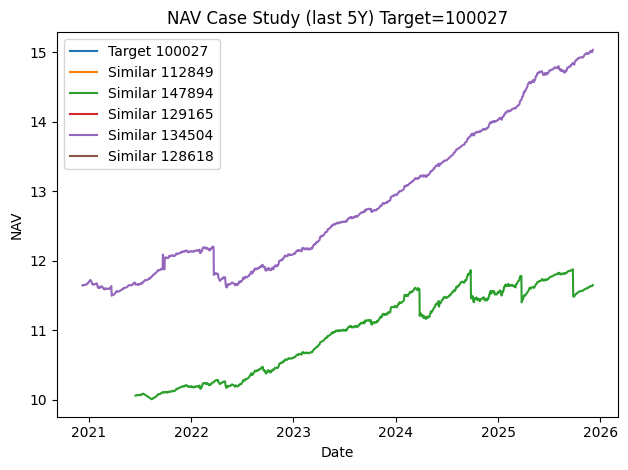


=== Paper-ready table: Top 20 Ranked Funds ===
 schemeCode                                                                                                schemeName     score      cagr   ann_vol  max_drawdown     sharpe
     112041                                                              Shinsei Liquid Fund - Institutional - Growth 64.910353 24.135742 74.930323      0.000000   0.757349
     112040                                                                     Shinsei Liquid Fund - Retail - Growth 64.868572 24.120512 74.928802      0.000000   0.757343
     112051                                                            Shinsei Liquid Fund - Retail - Weekly Dividend 61.544604 22.911719 74.929233     -0.001202   0.756795
     112049                                                      Shinsei Liquid Fund - Institutional - Daily Dividend 61.498146 22.894054 75.007245     -0.000449   0.757649
     112052                                                             Shinsei Liquid 

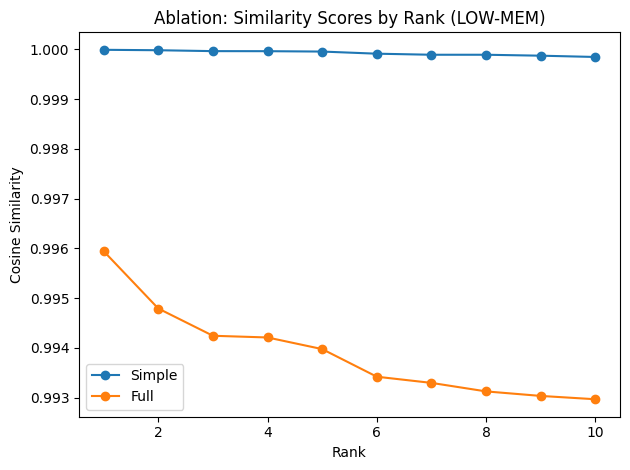

c:\Users\patel\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\patel\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\patel\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\patel\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\patel\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


KeyError: '[106864, 106935, 106936, 106934, 105613] not in index'

In [ ]:
# =========================================================
# EXECUTION EXAMPLE: Complete Fund Recommendation Pipeline
# =========================================================
# This cell demonstrates the full end-to-end workflow.
# Edit scheme codes and parameters to match your use case.

# Step 1: Build the recommender system
# min_obs=100 filters out funds with < 100 daily observations
# build_wide_returns=True creates the date x fund returns matrix (required for diversification)
art = build_recommenders_lowmem(maindf, min_obs=100, build_wide_returns=False)

# Step 2: Find similar funds to a target
# Example: find 10 funds similar to scheme code 100027
sim = recommend_similar_topk(100027, art["features"], art["Xn"], art["codes"], k=10)
print("=== Similar Funds ===")
print(sim)

# Step 3: Recommend funds by risk profile
# Choose from: "Conservative", "Moderate", "Aggressive"
risk = recommend_by_risk_profile("Conservative", art["features_bucketed"], k=10)
print("\n=== Conservative Risk Profile Recommendations ===")
print(risk)

# Step 4: View overall fund rankings
print("\n=== Top 20 Ranked Funds ===")
print(art["ranked"].head(20))

# Step 5: Visualize a case study (NAV plot)
sim5 = plot_nav_case_study(art, target_code=100027, k_similar=5, window_years=5)

# Step 6: Generate publication-ready tables
top_ranked, bucket_summary = paper_tables(art, top_n=20)

# Step 7: Ablation study (validate feature importance)
simple, full, side = ablation_similarity_comparison_lowmem(art, target_code=100027, k=10)

# Step 8 (Optional): Diversification analysis
# Only run if you built with build_wide_returns=True
if art["wide_returns"] is not None:
    art2 = build_recommenders_lowmem(maindf, min_obs=100, build_wide_returns=True)
    div = recommend_diversifiers_proxy(
        art2["wide_returns"],
        [100027, 123456, 777777],  # Edit with your portfolio scheme codes
        art2["features"],
        k=10
    )
    print("\n=== Diversification Recommendations ===")
    print(div)